# Assignment 1: Convolutional Neural Networks for image classification

In [ ]:
# impor library

import numpy as np
import pickle
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.models as models
import matplotlib.pyplot as plt

### Load and process data

In [2]:
# import the data from provided website

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

dataset_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
test_file = 'test_batch'

train_data = []
train_labels = []
for file_name in dataset_files:
        batch = unpickle(file_name)
        train_data.append(batch[b'data'])
        train_labels.extend(batch[b'labels'])
train_data = np.vstack(train_data)
train_labels = np.array(train_labels)

test_batch = unpickle(test_file)
test_data = test_batch[b'data']
test_labels = np.array(test_batch[b'labels'])


# pre process for the data for later training

train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0

In [ ]:
# Convert data to PyTorch tensors and permute dimensions
train_data_tensor = torch.tensor(train_data).permute(0, 3, 1, 2).float()
train_labels_tensor = torch.tensor(train_labels).long()
full_train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)

train_dataset, val_dataset = random_split(full_train_dataset, [40000, 10000])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_data_tensor = torch.tensor(test_data).permute(0, 3, 1, 2).float()
test_labels_tensor = torch.tensor(test_labels).long()
test_loader = DataLoader(TensorDataset(test_data_tensor, test_labels_tensor), batch_size=64, shuffle=False)

### Implement base model

In [4]:
class AlexNet_CIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet_CIFAR10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Modified from kernel_size=11, stride=4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),  # adjusted for CIFAR-10 32x32 images
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [5]:
resnet18 = models.resnet18(weights=None, num_classes=10)
alexnet = AlexNet_CIFAR10(num_classes=10)
mobilenet_v2 = models.mobilenet_v2(weights=None, num_classes=10)

### Train base model and test against val set

In [ ]:
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, test_loader=None, epochs=10, learning_rate=0.01):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Accumulate loss and accuracy for training
            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        # Calculate average training loss and accuracy
        train_loss = running_train_loss / total_train
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate loss and accuracy for validation
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss = running_val_loss / total_val
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


    if test_loader:
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_accuracy = 100 * test_correct / test_total
        print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

Training ResNet-18 baseline model...
Epoch [1/10], Train Loss: 1.6273, Train Accuracy: 42.57%, Validation Loss: 1.5098, Validation Accuracy: 47.94%
Epoch [2/10], Train Loss: 1.2085, Train Accuracy: 57.97%, Validation Loss: 1.1663, Validation Accuracy: 59.24%
Epoch [3/10], Train Loss: 0.9831, Train Accuracy: 65.79%, Validation Loss: 1.1139, Validation Accuracy: 61.24%
Epoch [4/10], Train Loss: 0.8247, Train Accuracy: 71.12%, Validation Loss: 0.9781, Validation Accuracy: 66.85%
Epoch [5/10], Train Loss: 0.6997, Train Accuracy: 75.54%, Validation Loss: 1.0364, Validation Accuracy: 66.56%
Epoch [6/10], Train Loss: 0.6015, Train Accuracy: 78.86%, Validation Loss: 0.9575, Validation Accuracy: 68.55%
Epoch [7/10], Train Loss: 0.5029, Train Accuracy: 82.34%, Validation Loss: 0.9961, Validation Accuracy: 68.99%
Epoch [8/10], Train Loss: 0.4234, Train Accuracy: 84.99%, Validation Loss: 1.2670, Validation Accuracy: 65.88%
Epoch [9/10], Train Loss: 0.3515, Train Accuracy: 87.72%, Validation Loss: 

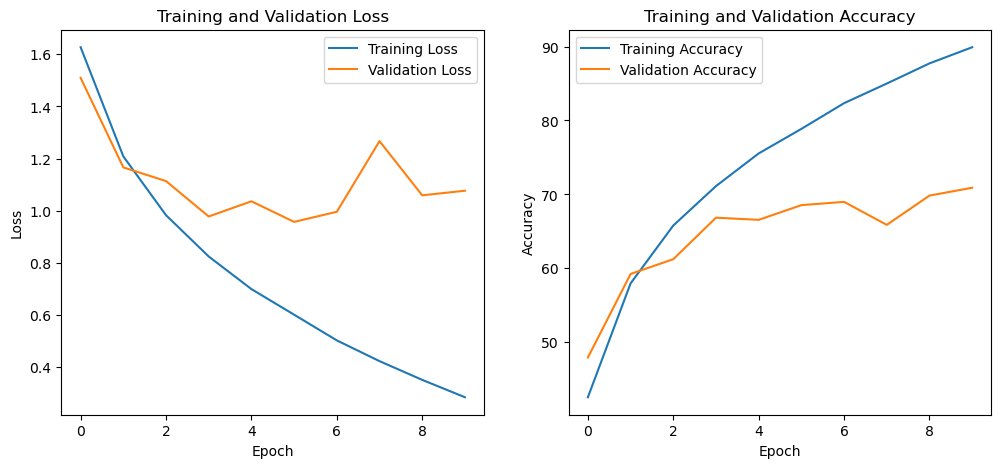

In [ ]:
print("Training ResNet-18 baseline model...")
train_losses, train_accuracies, val_losses, val_accuracies = train_model(resnet18, train_loader, val_loader, epochs=10)

# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Training AlexNet baseline model...
Epoch [1/10], Train Loss: 2.2863, Train Accuracy: 11.29%, Validation Loss: 2.1450, Validation Accuracy: 19.61%
Epoch [2/10], Train Loss: 1.9487, Train Accuracy: 26.34%, Validation Loss: 1.7233, Validation Accuracy: 33.53%
Epoch [3/10], Train Loss: 1.6114, Train Accuracy: 39.20%, Validation Loss: 1.4552, Validation Accuracy: 45.90%
Epoch [4/10], Train Loss: 1.3789, Train Accuracy: 49.19%, Validation Loss: 1.2687, Validation Accuracy: 53.61%
Epoch [5/10], Train Loss: 1.1884, Train Accuracy: 56.98%, Validation Loss: 1.0652, Validation Accuracy: 61.70%
Epoch [6/10], Train Loss: 1.0306, Train Accuracy: 63.10%, Validation Loss: 0.9270, Validation Accuracy: 66.67%
Epoch [7/10], Train Loss: 0.9114, Train Accuracy: 67.72%, Validation Loss: 0.9252, Validation Accuracy: 67.75%
Epoch [8/10], Train Loss: 0.7969, Train Accuracy: 71.81%, Validation Loss: 0.7907, Validation Accuracy: 72.64%
Epoch [9/10], Train Loss: 0.7137, Train Accuracy: 75.18%, Validation Loss: 0.

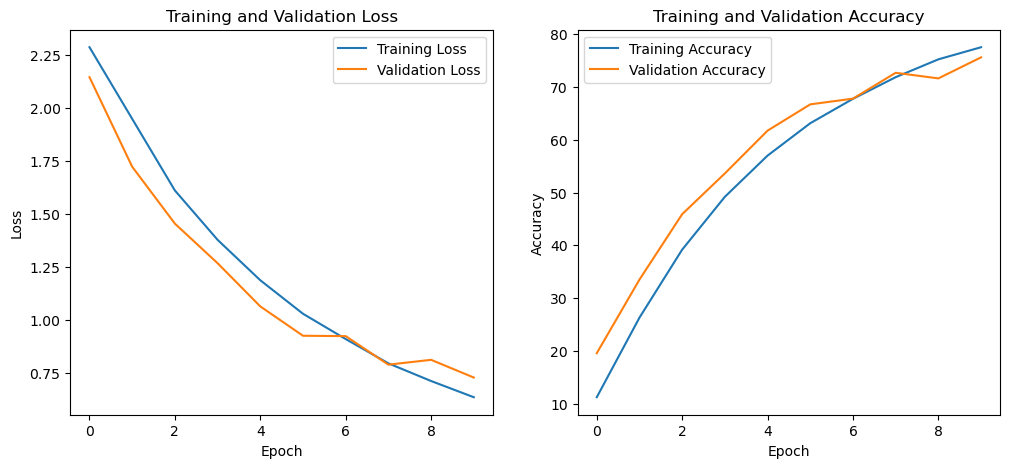

In [ ]:
print("Training AlexNet baseline model...")
train_losses, train_accuracies, val_losses, val_accuracies = train_model(alexnet, train_loader, val_loader, epochs=10)

# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Training MobileNetV2 baseline model...
Epoch [1/10], Train Loss: 1.9730, Train Accuracy: 30.31%, Validation Loss: 1.7209, Validation Accuracy: 36.02%
Epoch [2/10], Train Loss: 1.6679, Train Accuracy: 41.82%, Validation Loss: 1.5298, Validation Accuracy: 45.29%
Epoch [3/10], Train Loss: 1.5364, Train Accuracy: 46.34%, Validation Loss: 1.4454, Validation Accuracy: 48.09%
Epoch [4/10], Train Loss: 1.4207, Train Accuracy: 50.25%, Validation Loss: 1.3690, Validation Accuracy: 51.26%
Epoch [5/10], Train Loss: 1.3476, Train Accuracy: 52.96%, Validation Loss: 1.3354, Validation Accuracy: 53.99%
Epoch [6/10], Train Loss: 1.2969, Train Accuracy: 55.24%, Validation Loss: 1.2408, Validation Accuracy: 56.40%
Epoch [7/10], Train Loss: 1.1906, Train Accuracy: 58.49%, Validation Loss: 1.1781, Validation Accuracy: 58.12%
Epoch [8/10], Train Loss: 1.0927, Train Accuracy: 61.88%, Validation Loss: 1.1857, Validation Accuracy: 58.91%
Epoch [9/10], Train Loss: 1.0655, Train Accuracy: 62.94%, Validation Loss

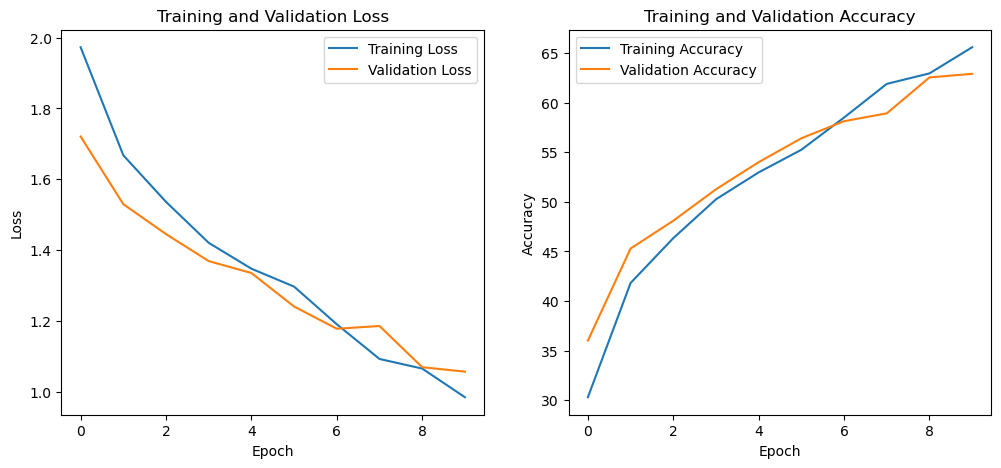

In [ ]:
print("Training MobileNetV2 baseline model...")
train_losses, train_accuracies, val_losses, val_accuracies = train_model(mobilenet_v2, train_loader, val_loader, epochs=10)

# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

### Hyperparameter Tuning

In [ ]:
def train_model(model, train_data, val_data, learning_rate=0.001, batch_size=32, epochs=10):
    # Create DataLoaders with the specified batch size
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    # Set up optimizer and loss function
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss and accuracy for training
            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Calculate average training loss and accuracy
        train_loss = running_train_loss / total_train
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate loss and accuracy for validation
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        # Calculate average validation loss and accuracy
        val_loss = running_val_loss / total_val
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)


        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return val_accuracy, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
# Define parameter grid
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]

# Dictionary to store results
results = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"\nTraining with Learning Rate: {lr}, Batch Size: {batch_size}")
        model = models.resnet18(weights=None, num_classes=10)  # Re-initialize model
        val_accuracy, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
            model, train_dataset, val_dataset, learning_rate=lr, batch_size=batch_size, epochs=25)
        
        results[(lr, batch_size)] = {
            'val_accuracy': val_accuracy,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }

# Find the best hyperparameter combination
best_params = max(results, key=lambda x: results[x]['val_accuracy'])
best_val_accuracy = results[best_params]['val_accuracy']
print(f"\nBest Hyperparameters: Learning Rate = {best_params[0]}, Batch Size = {best_params[1]}")
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


Training with Learning Rate: 0.001, Batch Size: 32
Epoch [1/25], Train Loss: 1.6200, Train Accuracy: 41.05%, Validation Loss: 1.4282, Validation Accuracy: 48.87%
Epoch [2/25], Train Loss: 1.2705, Train Accuracy: 54.28%, Validation Loss: 1.2201, Validation Accuracy: 56.57%
Epoch [3/25], Train Loss: 1.0931, Train Accuracy: 61.24%, Validation Loss: 1.2400, Validation Accuracy: 57.81%
Epoch [4/25], Train Loss: 0.9422, Train Accuracy: 66.58%, Validation Loss: 1.0628, Validation Accuracy: 63.13%
Epoch [5/25], Train Loss: 0.8084, Train Accuracy: 71.46%, Validation Loss: 1.0583, Validation Accuracy: 64.46%
Epoch [6/25], Train Loss: 0.7032, Train Accuracy: 75.08%, Validation Loss: 1.0973, Validation Accuracy: 63.29%
Epoch [7/25], Train Loss: 0.6027, Train Accuracy: 78.66%, Validation Loss: 1.0406, Validation Accuracy: 66.86%
Epoch [8/25], Train Loss: 0.5182, Train Accuracy: 81.47%, Validation Loss: 1.1668, Validation Accuracy: 64.51%
Epoch [9/25], Train Loss: 0.4283, Train Accuracy: 84.73%, Va

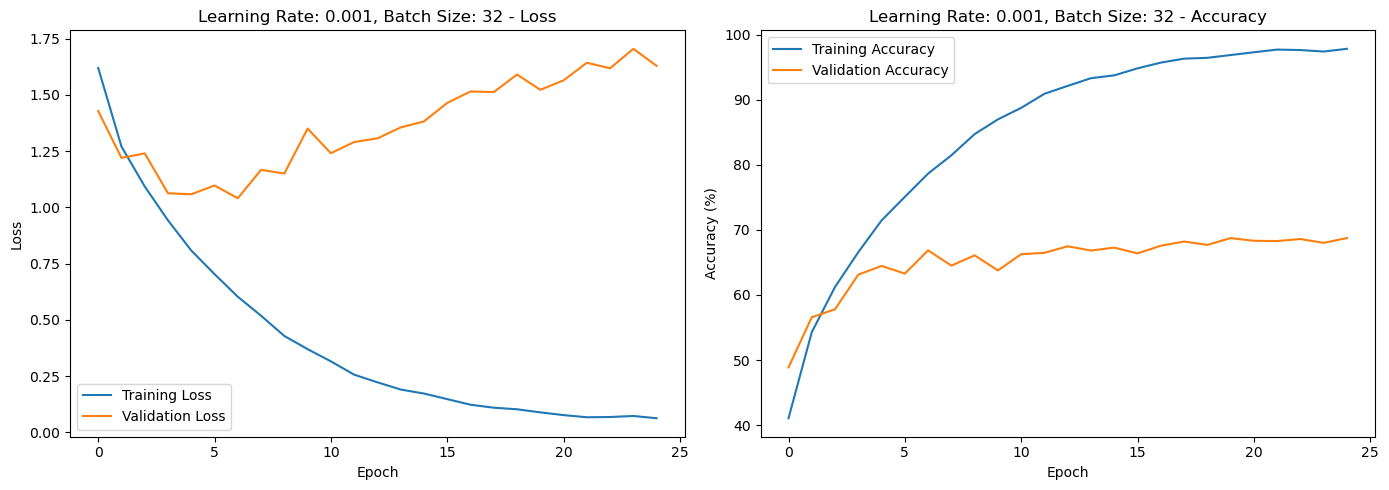

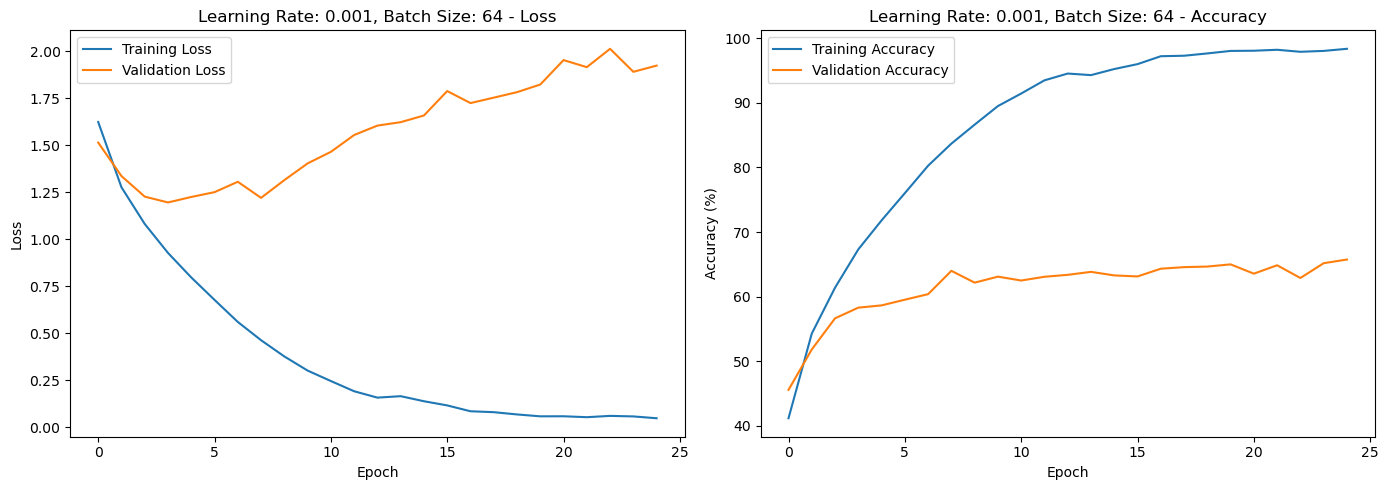

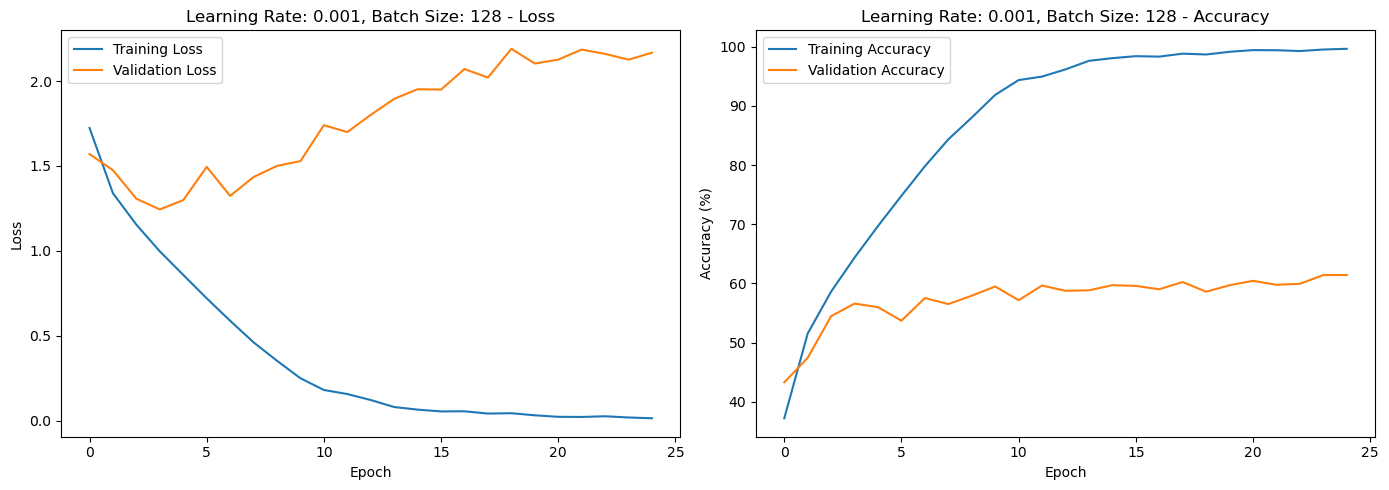

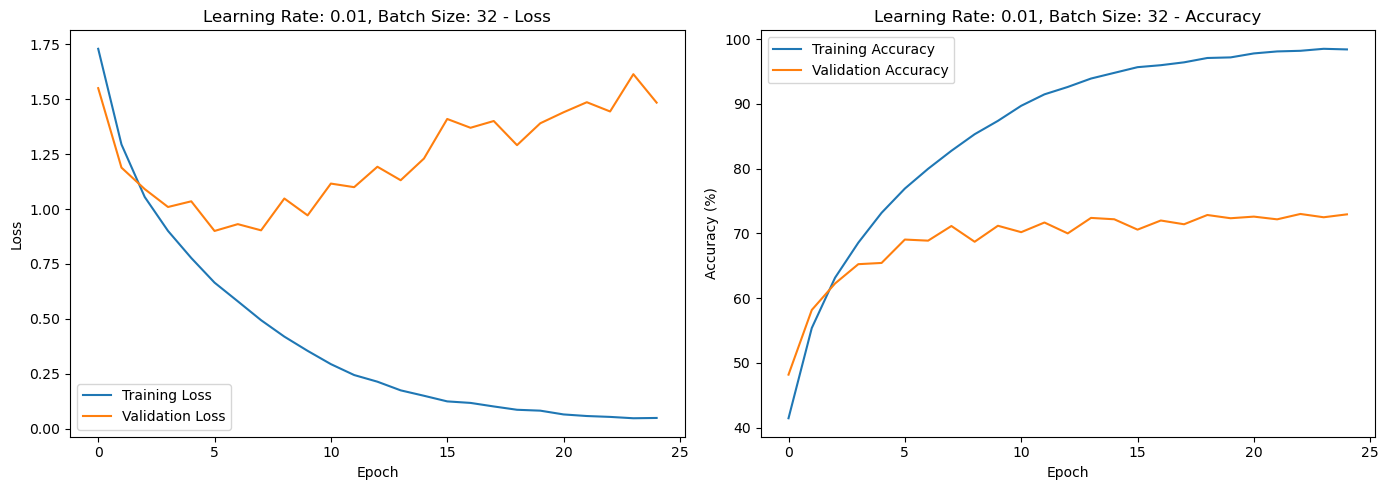

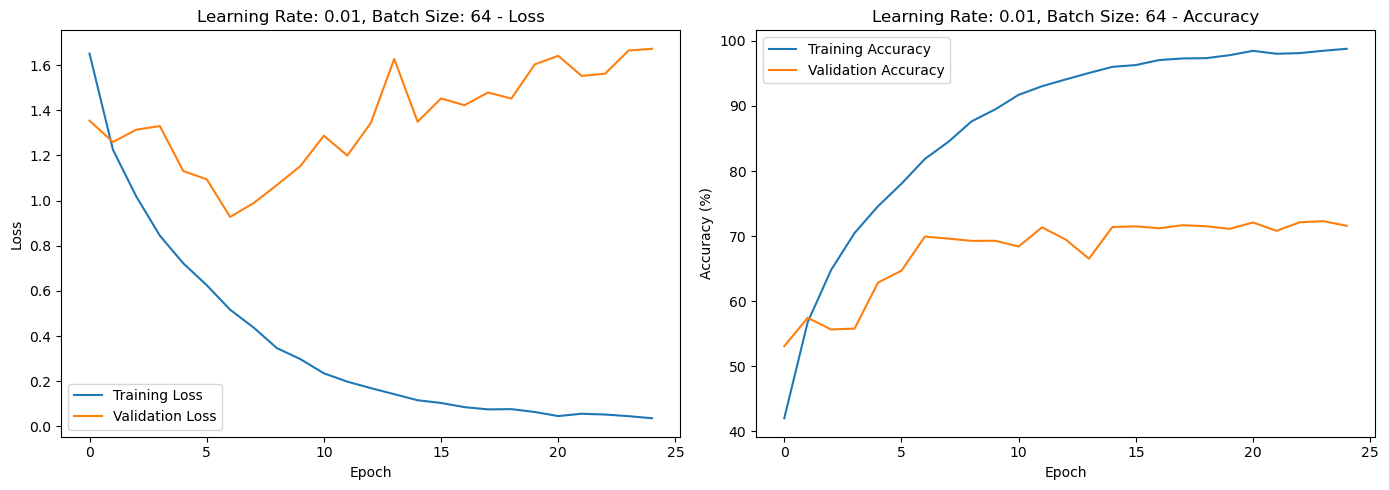

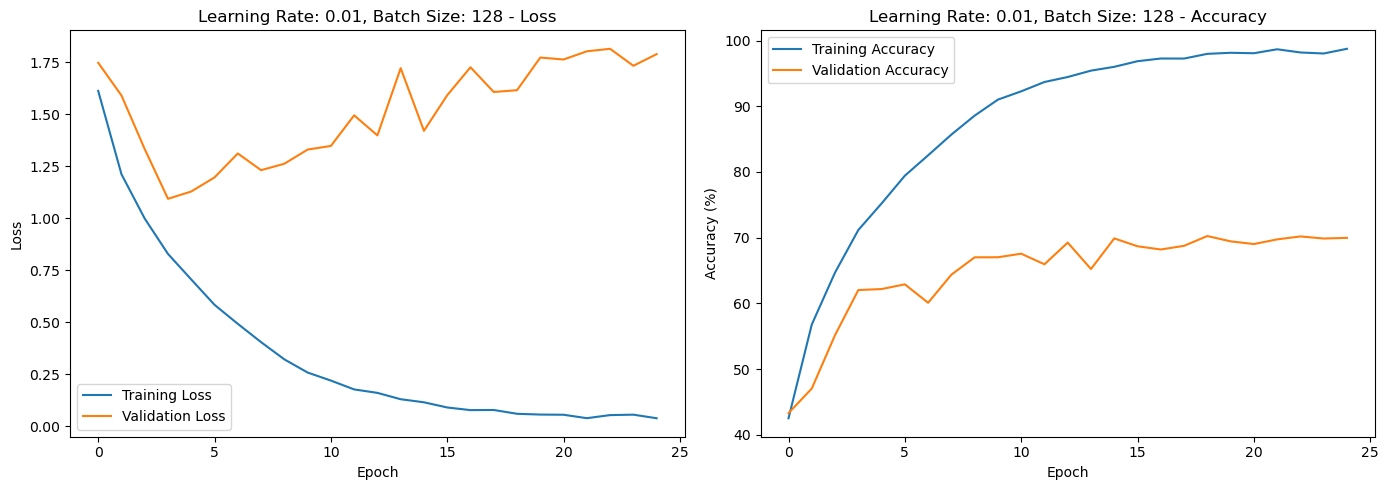

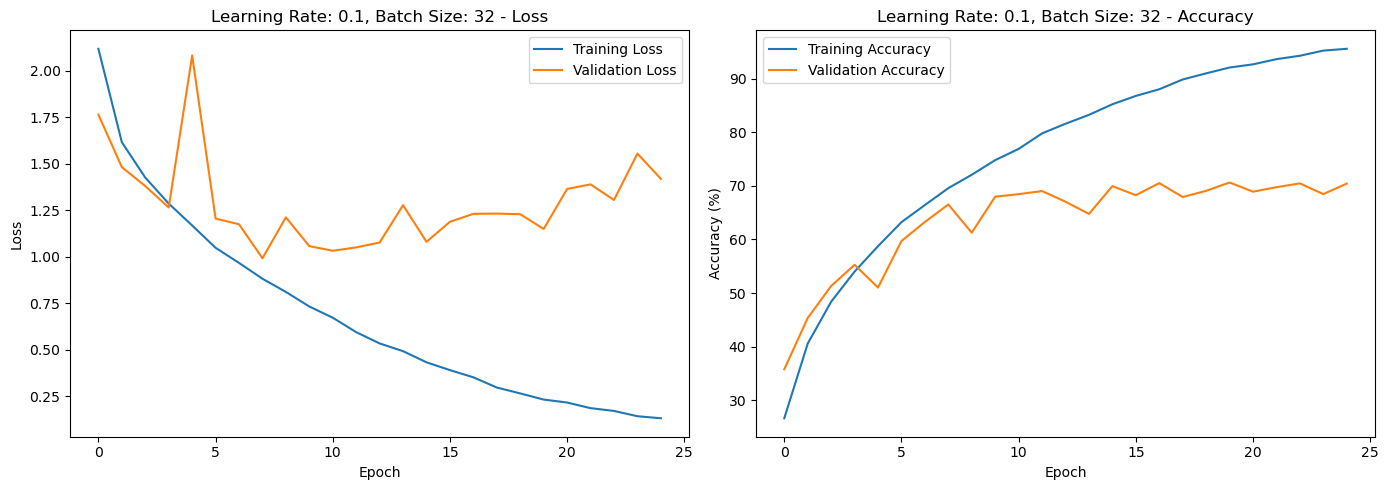

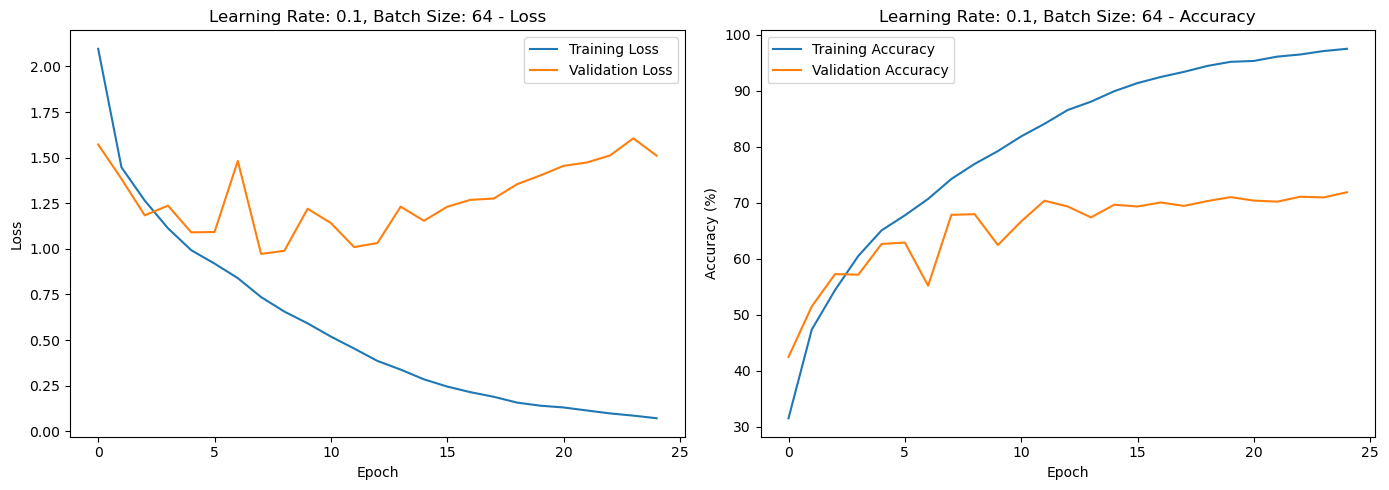

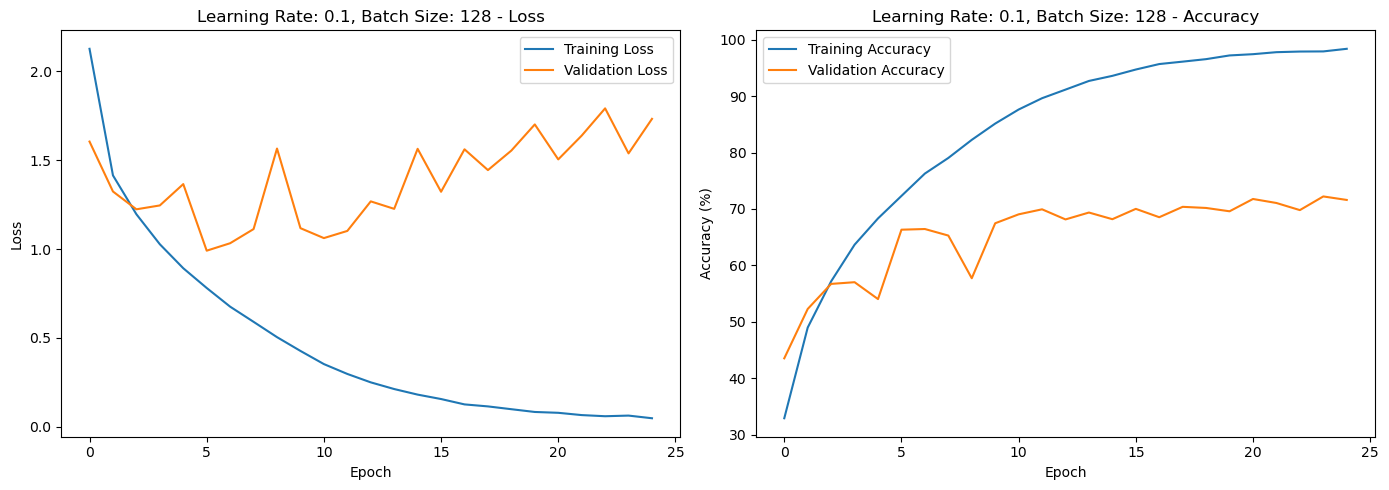

In [ ]:
for (lr, batch_size), metrics in results.items():
    train_losses = metrics['train_losses']
    val_losses = metrics['val_losses']
    train_accuracies = metrics['train_accuracies']
    val_accuracies = metrics['val_accuracies']

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Learning Rate: {lr}, Batch Size: {batch_size} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Learning Rate: {lr}, Batch Size: {batch_size} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Dictionary to store results
results_alexnet = {}

# Loop through combinations of learning rate and batch size
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"\nTraining with Learning Rate: {lr}, Batch Size: {batch_size}")
        model = AlexNet_CIFAR10(num_classes=10)  # Re-initialize model
        val_accuracy, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
            model, train_dataset, val_dataset, learning_rate=lr, batch_size=batch_size, epochs=25)
        
        results_alexnet[(lr, batch_size)] = {
            'val_accuracy': val_accuracy,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }

# Find the best hyperparameter combination
best_params = max(results_alexnet, key=lambda x: results_alexnet[x]['val_accuracy'])
best_val_accuracy = results_alexnet[best_params]['val_accuracy']
print(f"\nBest Hyperparameters: Learning Rate = {best_params[0]}, Batch Size = {best_params[1]}")
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


Training with Learning Rate: 0.001, Batch Size: 32
Epoch [1/25], Train Loss: 2.3026, Train Accuracy: 10.11%, Validation Loss: 2.3025, Validation Accuracy: 9.92%
Epoch [2/25], Train Loss: 2.3022, Train Accuracy: 10.71%, Validation Loss: 2.3020, Validation Accuracy: 9.79%
Epoch [3/25], Train Loss: 2.3003, Train Accuracy: 11.33%, Validation Loss: 2.2957, Validation Accuracy: 16.51%
Epoch [4/25], Train Loss: 2.2099, Train Accuracy: 16.41%, Validation Loss: 2.0893, Validation Accuracy: 21.90%
Epoch [5/25], Train Loss: 2.0184, Train Accuracy: 24.59%, Validation Loss: 1.8901, Validation Accuracy: 28.54%
Epoch [6/25], Train Loss: 1.8603, Train Accuracy: 28.75%, Validation Loss: 1.7774, Validation Accuracy: 32.90%
Epoch [7/25], Train Loss: 1.7442, Train Accuracy: 33.55%, Validation Loss: 1.7153, Validation Accuracy: 35.83%
Epoch [8/25], Train Loss: 1.6429, Train Accuracy: 38.18%, Validation Loss: 1.5997, Validation Accuracy: 39.98%
Epoch [9/25], Train Loss: 1.5630, Train Accuracy: 41.68%, Vali

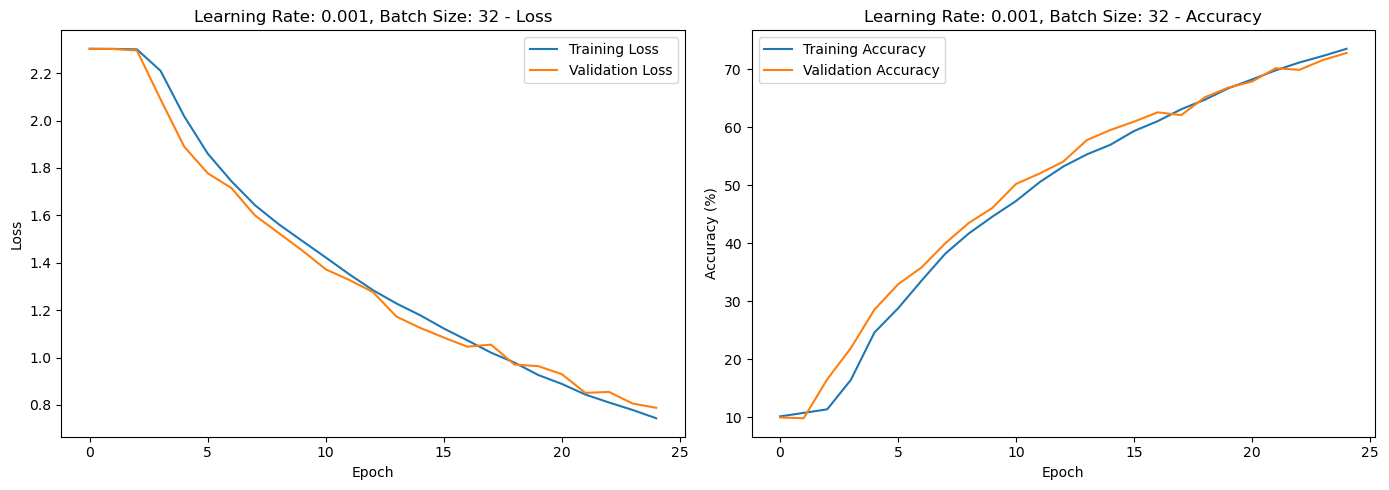

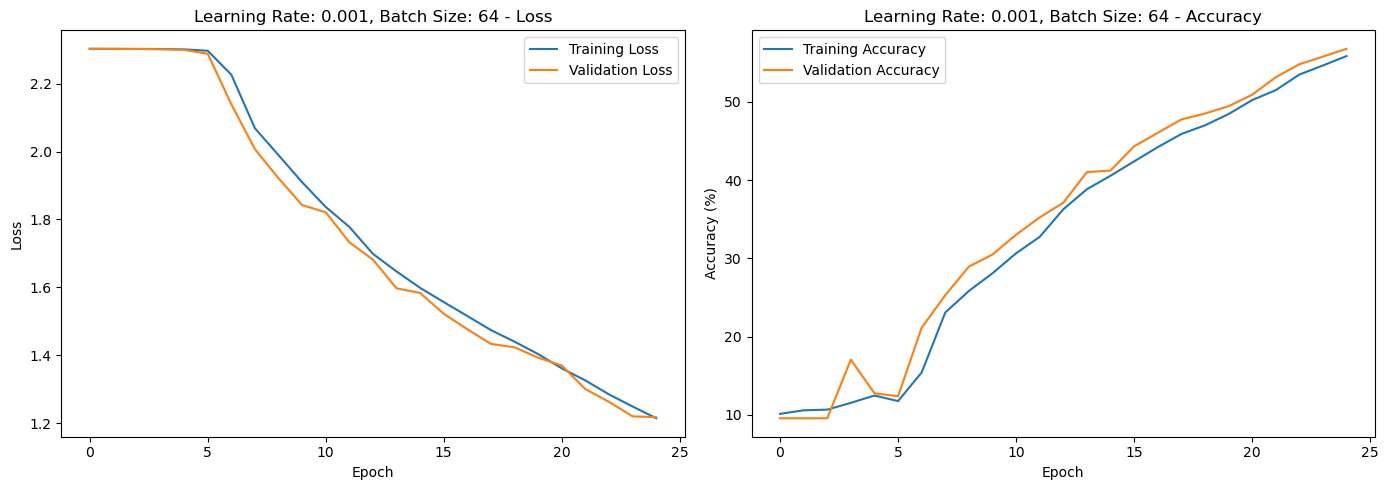

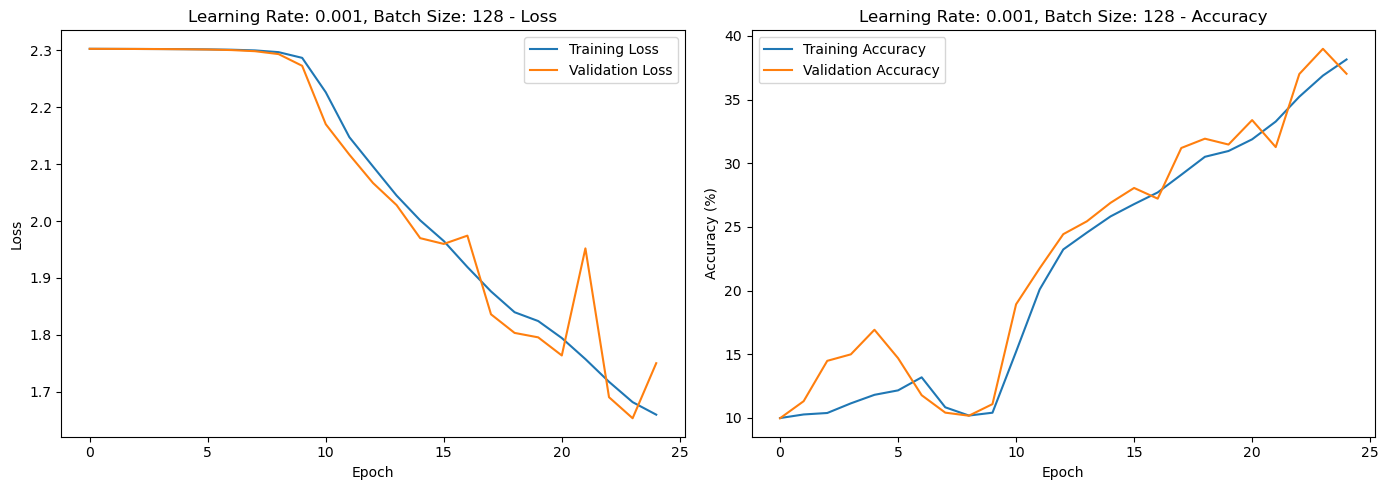

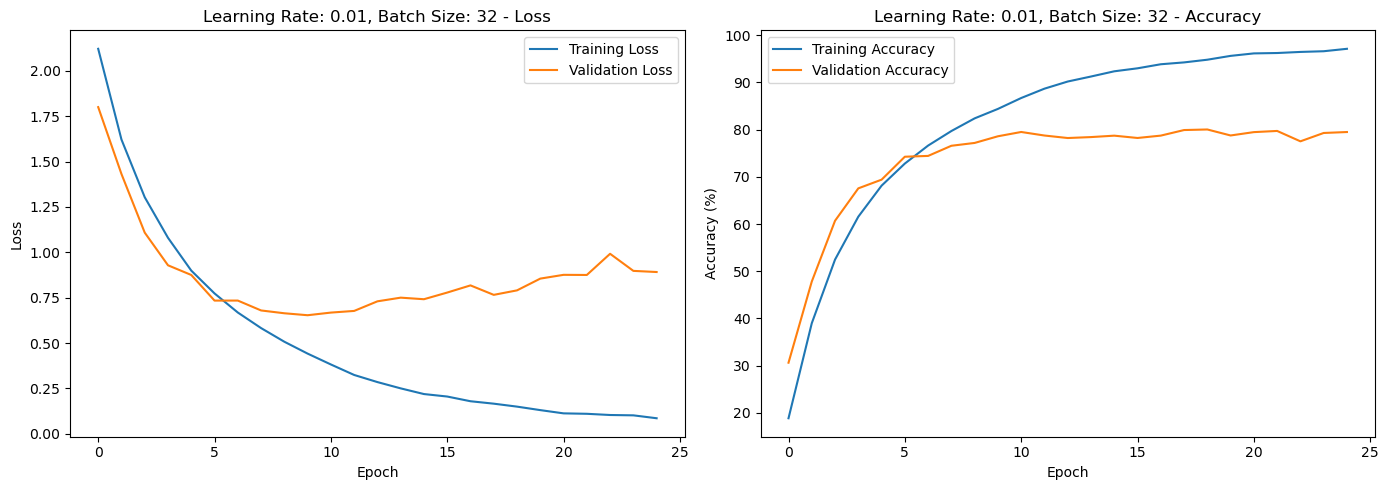

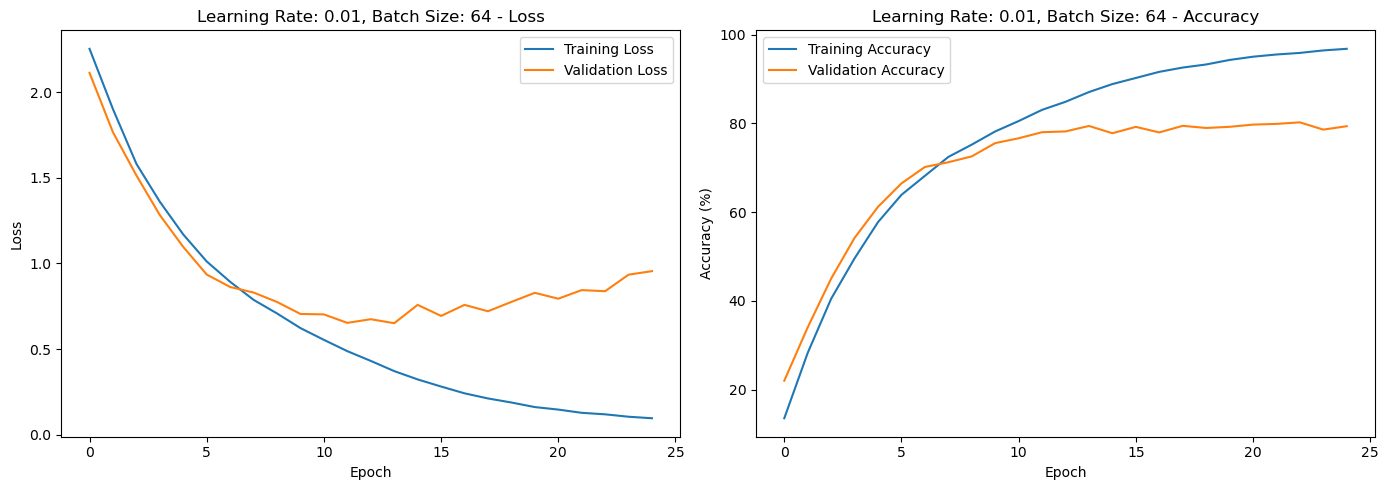

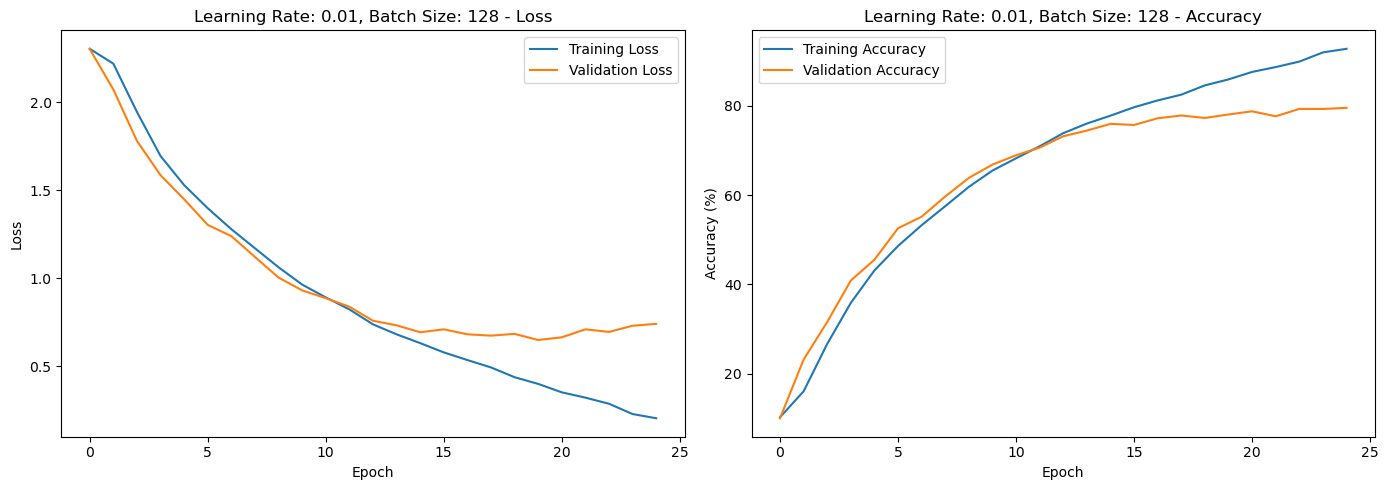

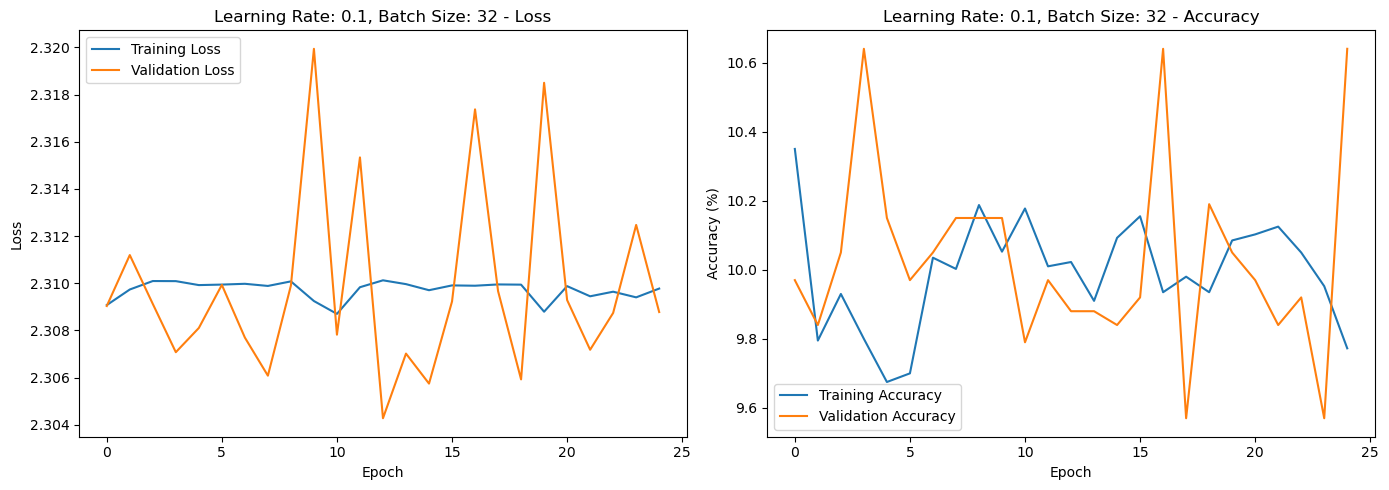

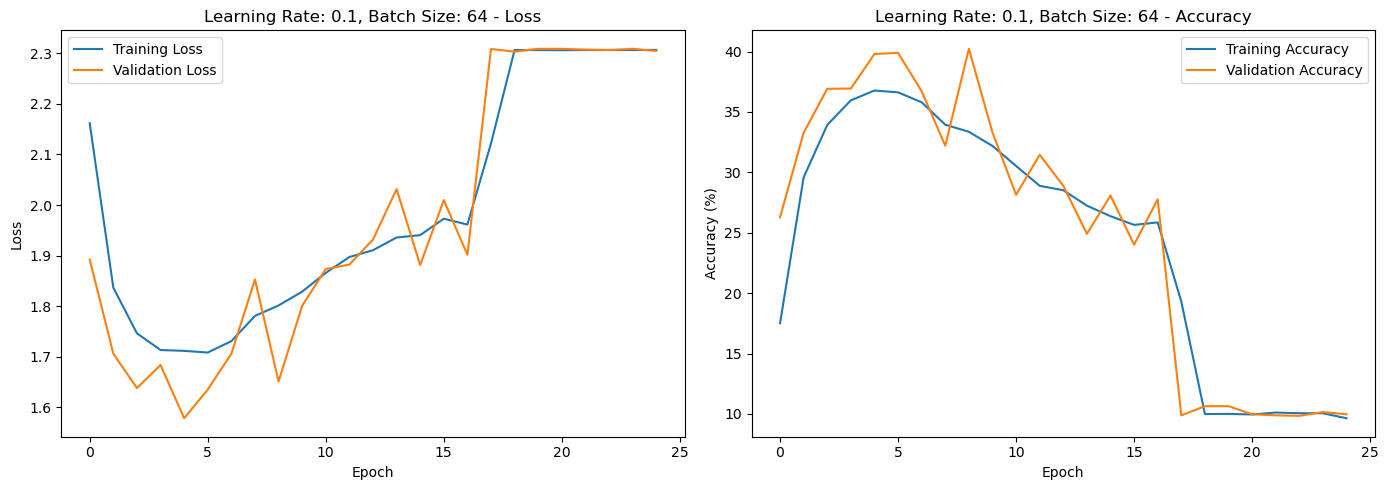

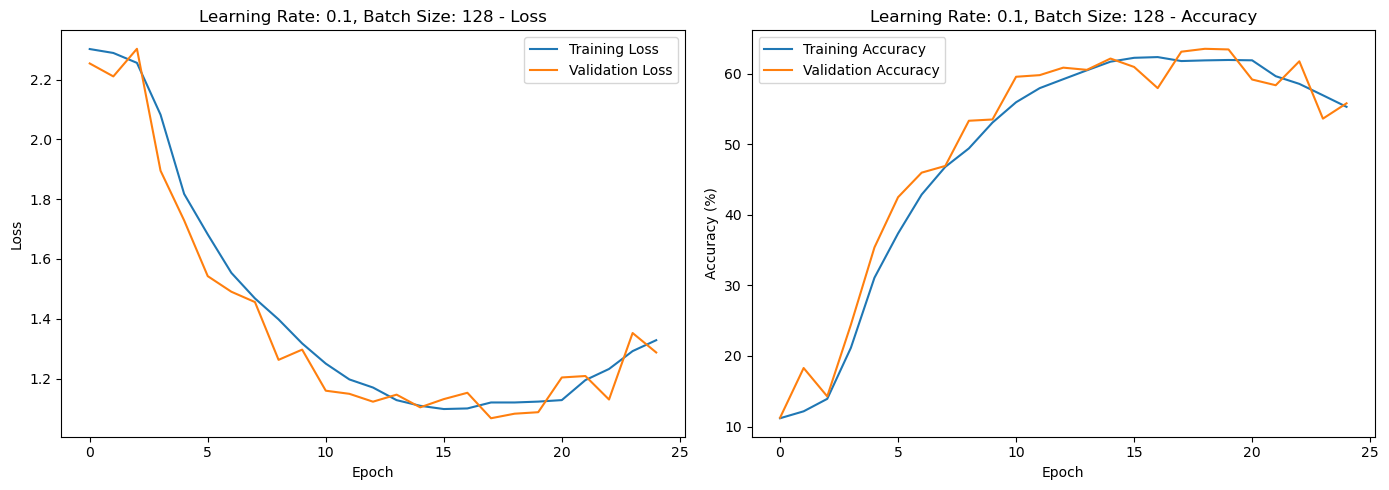

In [ ]:
for (lr, batch_size), metrics in results_alexnet.items():
    train_losses = metrics['train_losses']
    val_losses = metrics['val_losses']
    train_accuracies = metrics['train_accuracies']
    val_accuracies = metrics['val_accuracies']

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Learning Rate: {lr}, Batch Size: {batch_size} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Learning Rate: {lr}, Batch Size: {batch_size} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Dictionary to store results
results_mobilenet = {}

# Loop through combinations of learning rate and batch size
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"\nTraining with Learning Rate: {lr}, Batch Size: {batch_size}")
        model = models.mobilenet_v2(weights=None, num_classes=10)  # Re-initialize model
        val_accuracy, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
            model, train_dataset, val_dataset, learning_rate=lr, batch_size=batch_size, epochs=25)

        results_mobilenet[(lr, batch_size)] = {
            'val_accuracy': val_accuracy,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }

# Find the best hyperparameter combination
best_params = max(results_mobilenet, key=lambda x: results_mobilenet[x]['val_accuracy'])
best_val_accuracy = results_mobilenet[best_params]['val_accuracy']
print(f"\nBest Hyperparameters: Learning Rate = {best_params[0]}, Batch Size = {best_params[1]}")
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


Training with Learning Rate: 0.001, Batch Size: 32
Epoch [1/25], Train Loss: 1.9615, Train Accuracy: 26.51%, Validation Loss: 1.7231, Validation Accuracy: 35.93%
Epoch [2/25], Train Loss: 1.6804, Train Accuracy: 37.62%, Validation Loss: 1.5715, Validation Accuracy: 42.47%
Epoch [3/25], Train Loss: 1.5641, Train Accuracy: 42.31%, Validation Loss: 1.5019, Validation Accuracy: 44.82%
Epoch [4/25], Train Loss: 1.4811, Train Accuracy: 45.77%, Validation Loss: 1.4188, Validation Accuracy: 48.22%
Epoch [5/25], Train Loss: 1.4174, Train Accuracy: 48.53%, Validation Loss: 1.3642, Validation Accuracy: 50.35%
Epoch [6/25], Train Loss: 1.3629, Train Accuracy: 50.88%, Validation Loss: 1.3213, Validation Accuracy: 52.60%
Epoch [7/25], Train Loss: 1.3107, Train Accuracy: 52.37%, Validation Loss: 1.3015, Validation Accuracy: 53.70%
Epoch [8/25], Train Loss: 1.2640, Train Accuracy: 54.81%, Validation Loss: 1.2752, Validation Accuracy: 54.30%
Epoch [9/25], Train Loss: 1.2200, Train Accuracy: 56.47%, Va

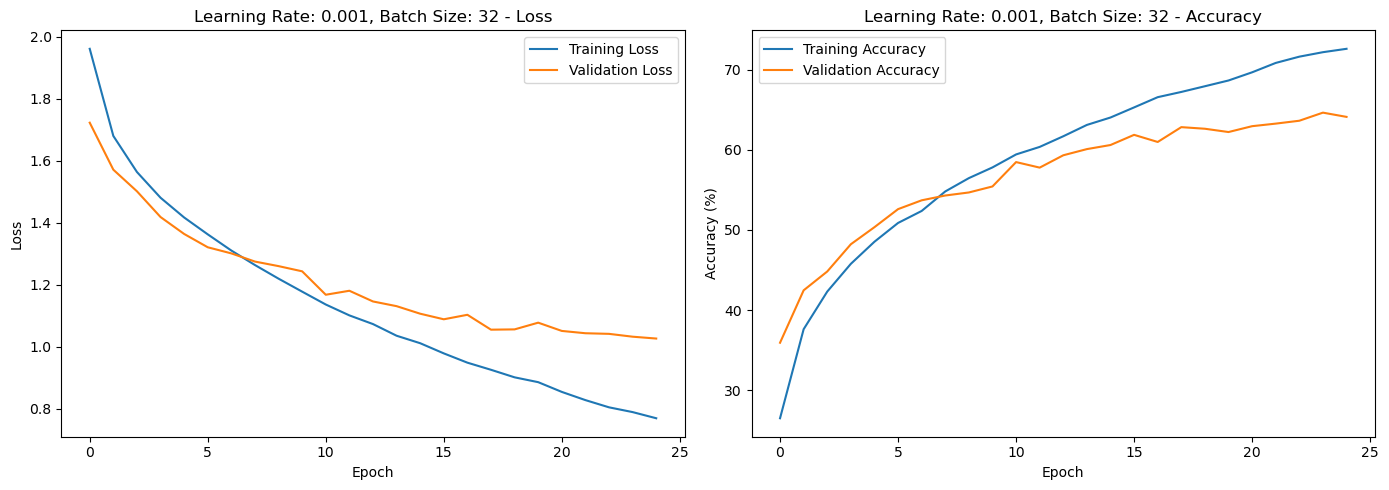

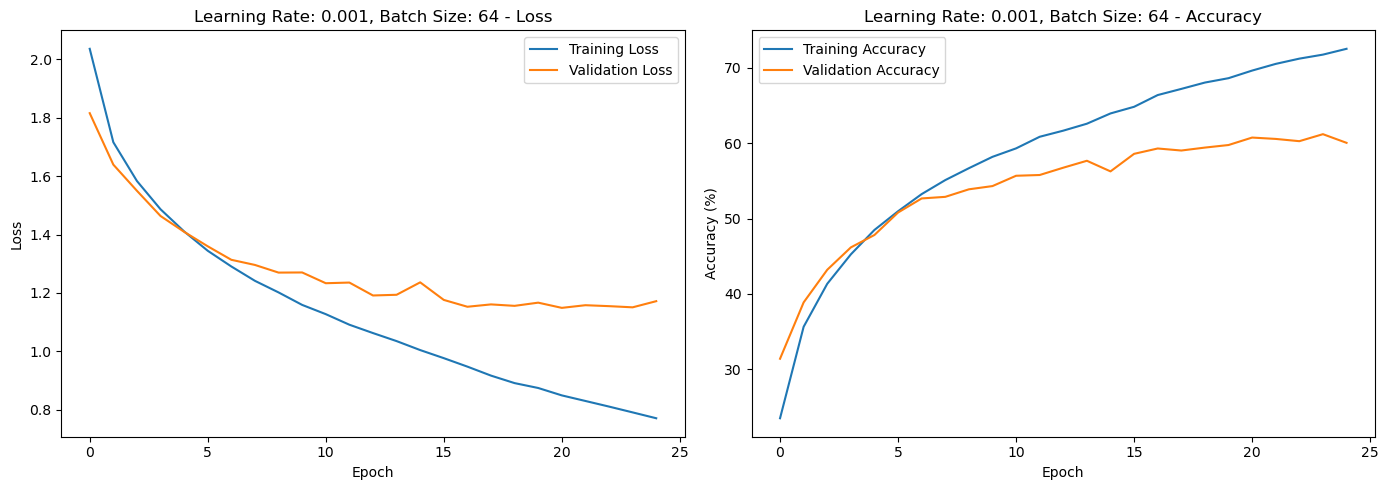

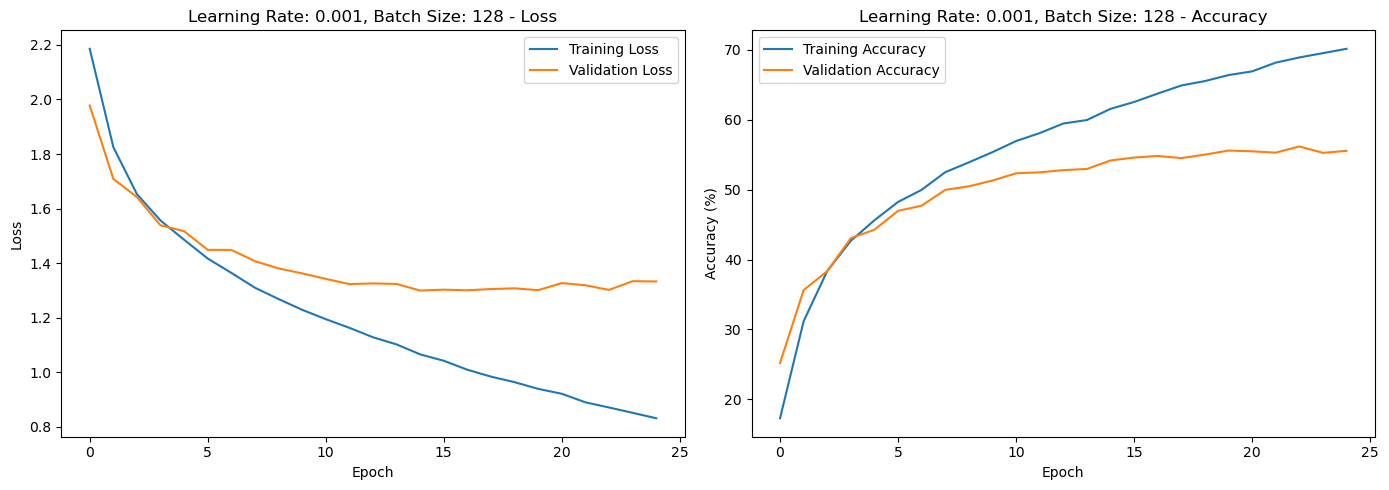

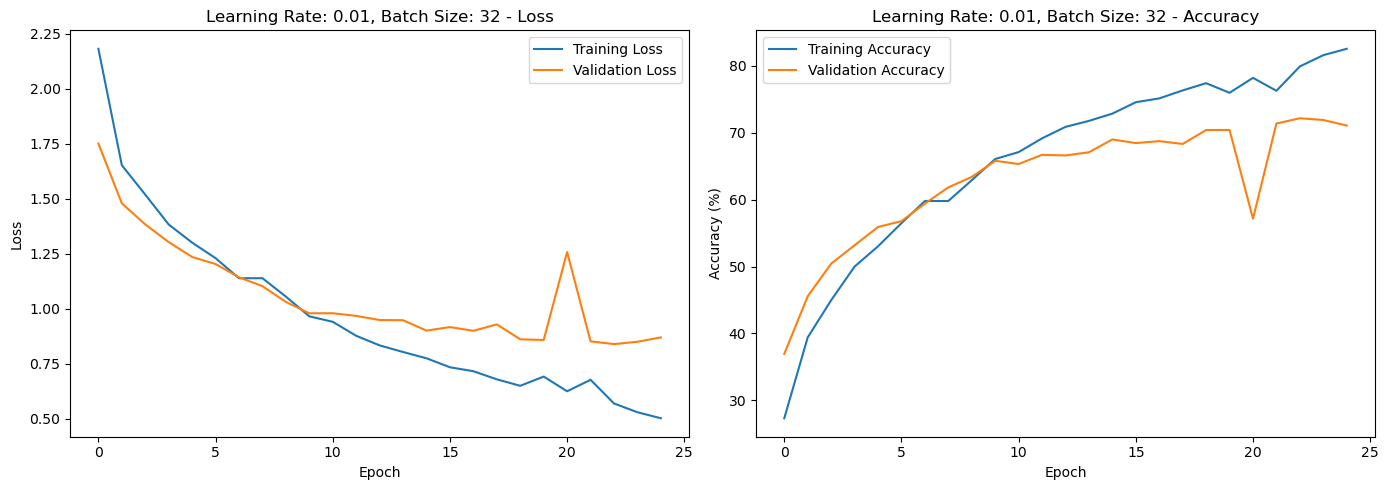

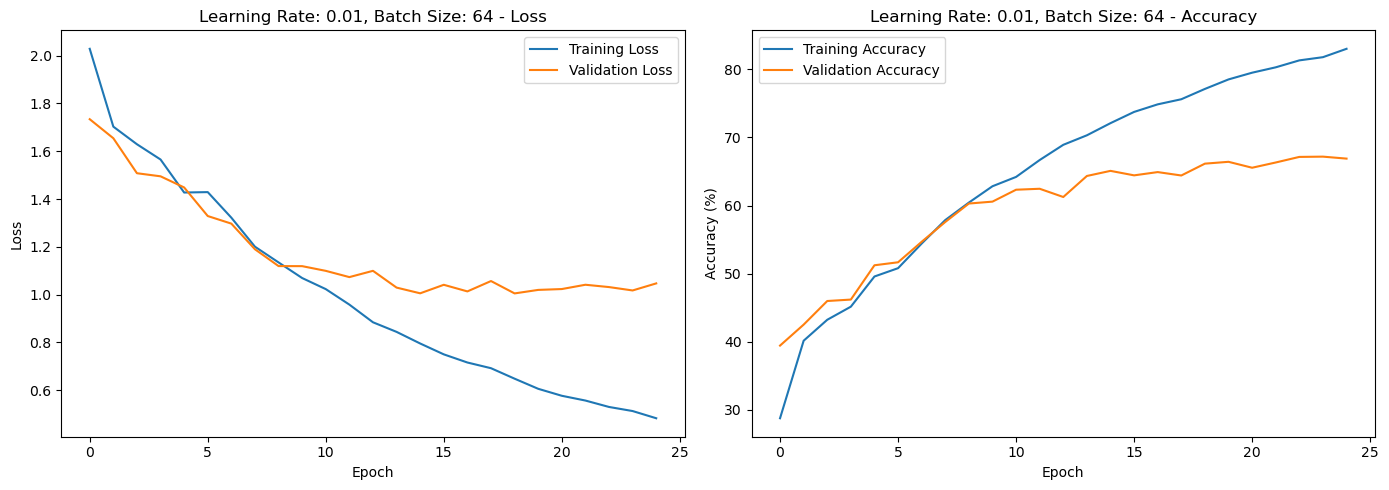

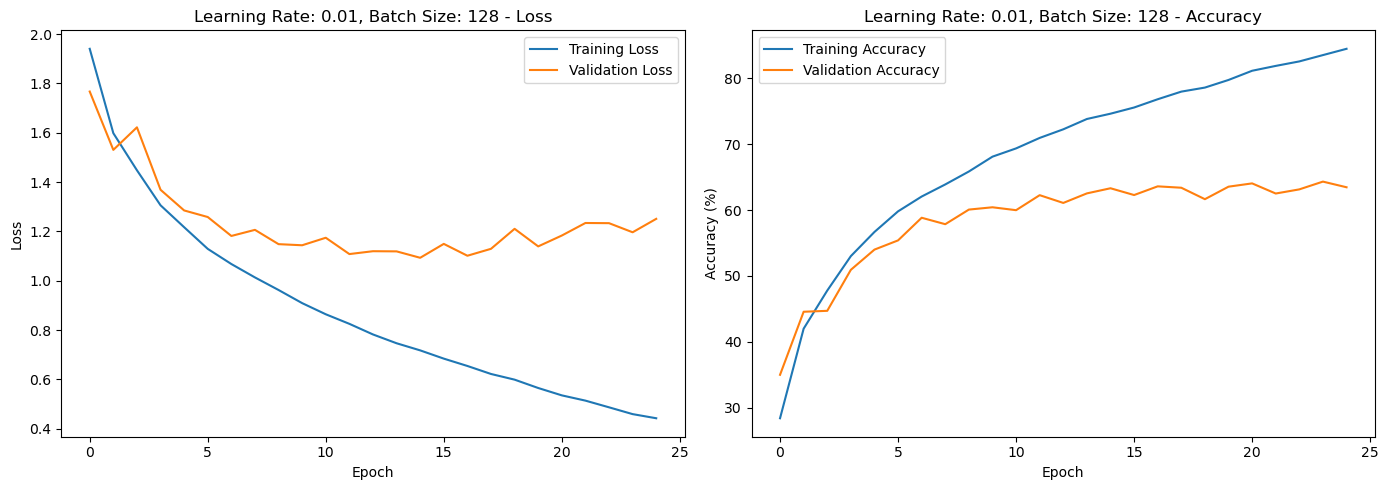

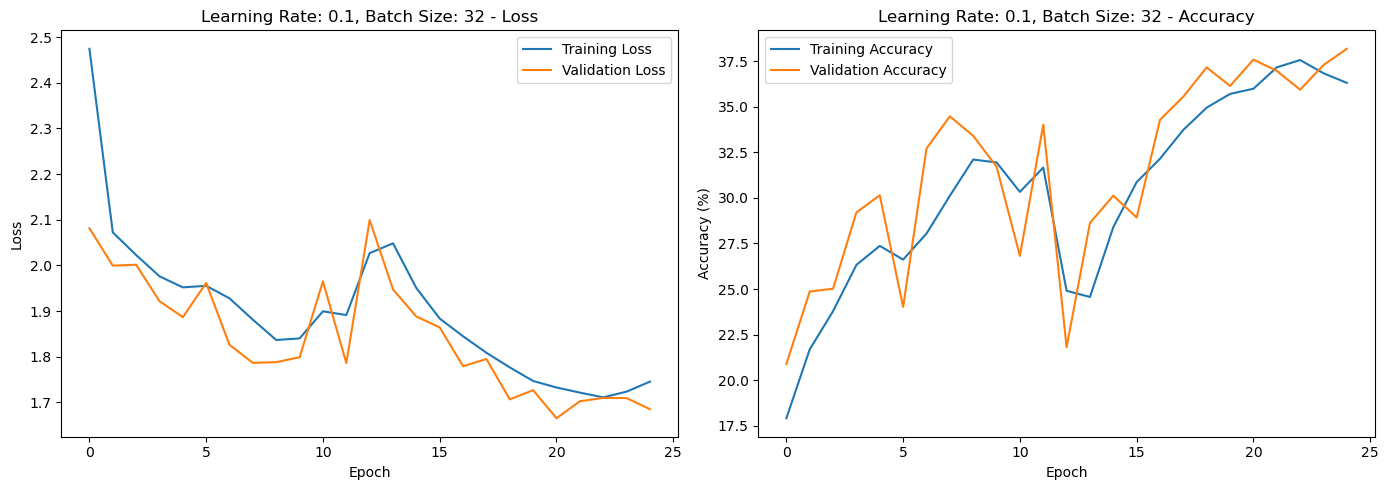

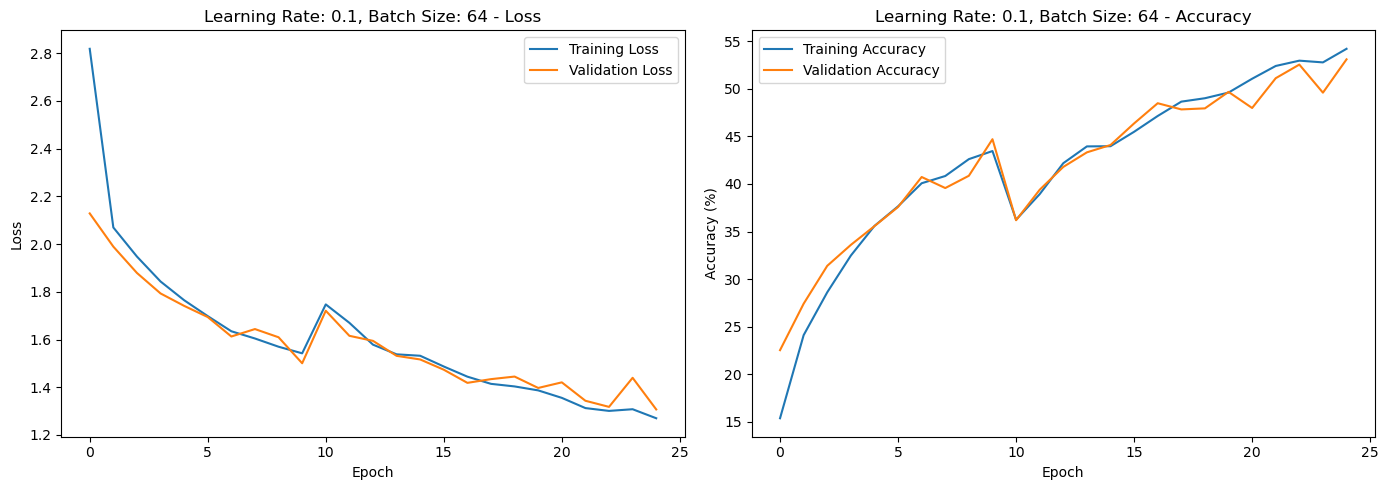

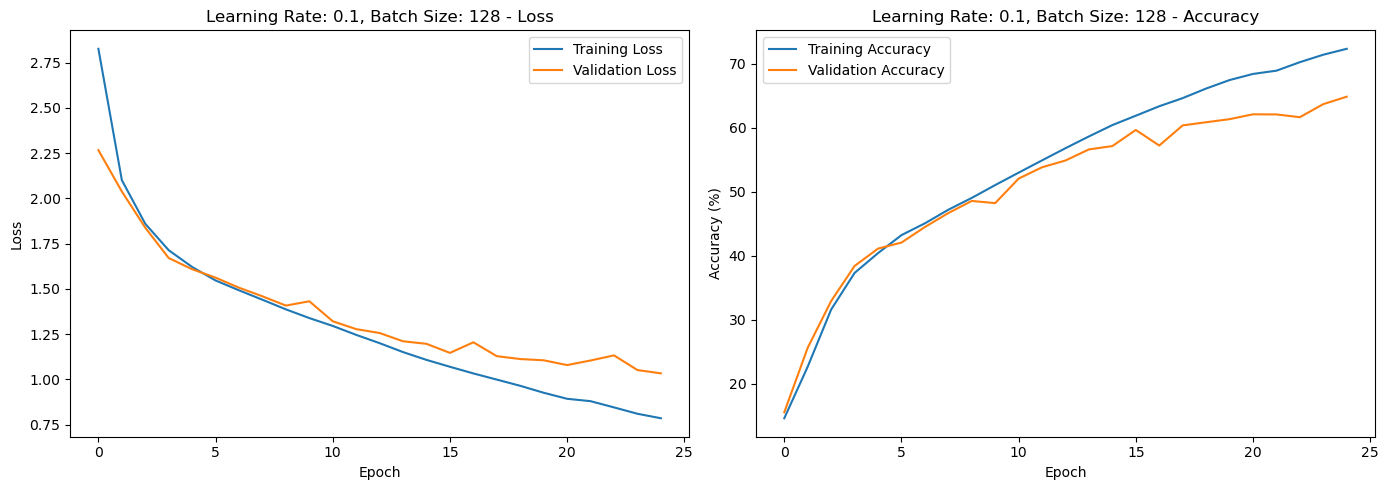

In [ ]:
for (lr, batch_size), metrics in results_mobilenet.items():
    train_losses = metrics['train_losses']
    val_losses = metrics['val_losses']
    train_accuracies = metrics['train_accuracies']
    val_accuracies = metrics['val_accuracies']

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Learning Rate: {lr}, Batch Size: {batch_size} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Learning Rate: {lr}, Batch Size: {batch_size} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Train the best model and test against test set

In [ ]:
def train_model(model, train_data, val_data, test_loader=None, learning_rate=0.001, batch_size=32, epochs=10):
    # Create DataLoaders with the specified batch size
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    # Set up optimizer and loss function
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss and accuracy for training
            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Calculate average training loss and accuracy
        train_loss = running_train_loss / total_train
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate loss and accuracy for validation
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        # Calculate average validation loss and accuracy
        val_loss = running_val_loss / total_val
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch metrics
        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Final evaluation on the test set if test_loader is provided
    if test_loader:
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_accuracy = 100 * test_correct / test_total
        print(f"Final Test Accuracy: {test_accuracy:.2f}%")

    # Return final validation accuracy for comparison
    return val_accuracy, train_losses, train_accuracies, val_losses, val_accuracies

In [20]:
# Dictionary to store results
final_result = {}

# Loop through combinations of learning rate and batch size

print(f"\nTraining with Learning Rate: 0.01, Batch Size: 128")
model = model = AlexNet_CIFAR10(num_classes=10)
val_accuracy, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_dataset, val_dataset, test_loader, learning_rate=0.01, batch_size=128, epochs=25)


Training with Learning Rate: 0.01, Batch Size: 128
Epoch [1/25], Train Loss: 2.3024, Train Accuracy: 9.96%, Validation Loss: 2.3008, Validation Accuracy: 9.61%
Epoch [2/25], Train Loss: 2.2038, Train Accuracy: 16.53%, Validation Loss: 2.0248, Validation Accuracy: 26.10%
Epoch [3/25], Train Loss: 1.9451, Train Accuracy: 27.12%, Validation Loss: 1.7748, Validation Accuracy: 33.24%
Epoch [4/25], Train Loss: 1.6972, Train Accuracy: 36.06%, Validation Loss: 1.5642, Validation Accuracy: 41.94%
Epoch [5/25], Train Loss: 1.5242, Train Accuracy: 43.16%, Validation Loss: 1.5186, Validation Accuracy: 43.60%
Epoch [6/25], Train Loss: 1.3893, Train Accuracy: 48.58%, Validation Loss: 1.2920, Validation Accuracy: 52.32%
Epoch [7/25], Train Loss: 1.2685, Train Accuracy: 53.44%, Validation Loss: 1.2218, Validation Accuracy: 55.89%
Epoch [8/25], Train Loss: 1.1550, Train Accuracy: 57.97%, Validation Loss: 1.0977, Validation Accuracy: 60.64%
Epoch [9/25], Train Loss: 1.0452, Train Accuracy: 62.48%, Vali

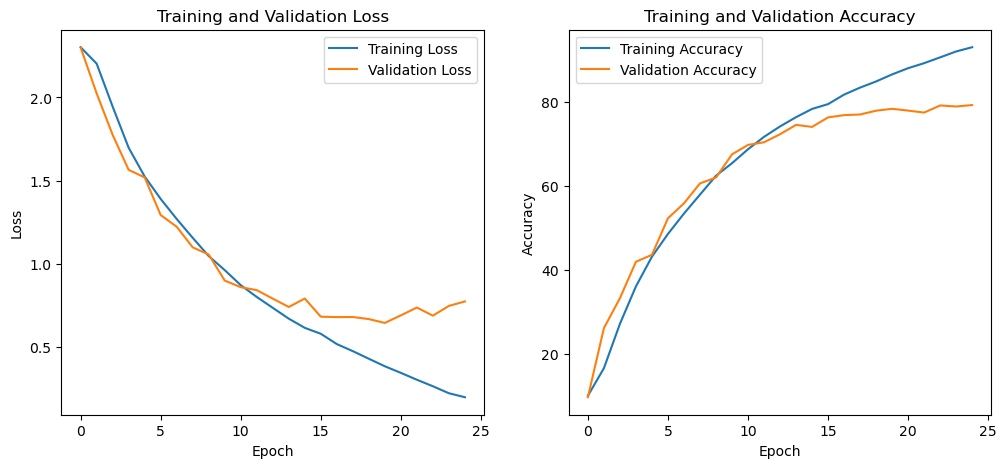

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()